<a href="https://colab.research.google.com/github/Gustavo-dev04/Analise-de-dados-de-acoes-com-ia/blob/main/modelo1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== SISTEMA DE PREVISÃO DE PREÇOS ===
(Modelo Híbrido LSTM + Análise Fundamentalista)

1. Faça upload do arquivo de preços (ex: NVDA.csv)


Saving NVDA.csv to NVDA (31).csv

2. Faça upload do arquivo financeiro (ex: NVDA_Financials.csv)


Saving NVDA_Financials.csv to NVDA_Financials (27).csv

3. Processando dados de preços...
✔ Dados carregados. Colunas disponíveis: ['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']

4. Processando dados financeiros...
✔ Dados financeiros carregados. Colunas: ['Period', 'Report Date', 'Revenue', 'Cost Of Revenue', 'Gross Profit', 'Gross Margin', 'Research And Development Expenses', 'Selling General And Administrative Expenses', 'Other Expenses', 'Operating Expenses', 'Operating Income', 'Operating Margin', 'Interest Expense', 'Total Other Income Expenses Net', 'Income Before Tax', 'Income Tax Expense', 'Net Income', 'Net Margin', 'EPS', 'EPSDILUTED', 'Weighted Average Shs Out', 'Weighted Average Shs Out Dil', 'EBITDA', 'Depreciation And Amortization']

5. Combinando dados...
✔ Dados combinados. Período: 2022-05-02 a 2025-02-26

6. Preparando modelo...

🔧 Features técnicas selecionadas (14): ['Open', 'High', 'Low', 'Volume', 'Range', 'Avg_Price', 'MA_5', 'MA_10', 'MA_20', 'Volatility'


📊 DESEMPENHO DO MODELO:
• Erro Médio Absoluto (MAE): $3.24
• Raiz do Erro Quadrático Médio (RMSE): $4.20

9. Gerando previsões para 30 dias...

10. Gerando visualizações...


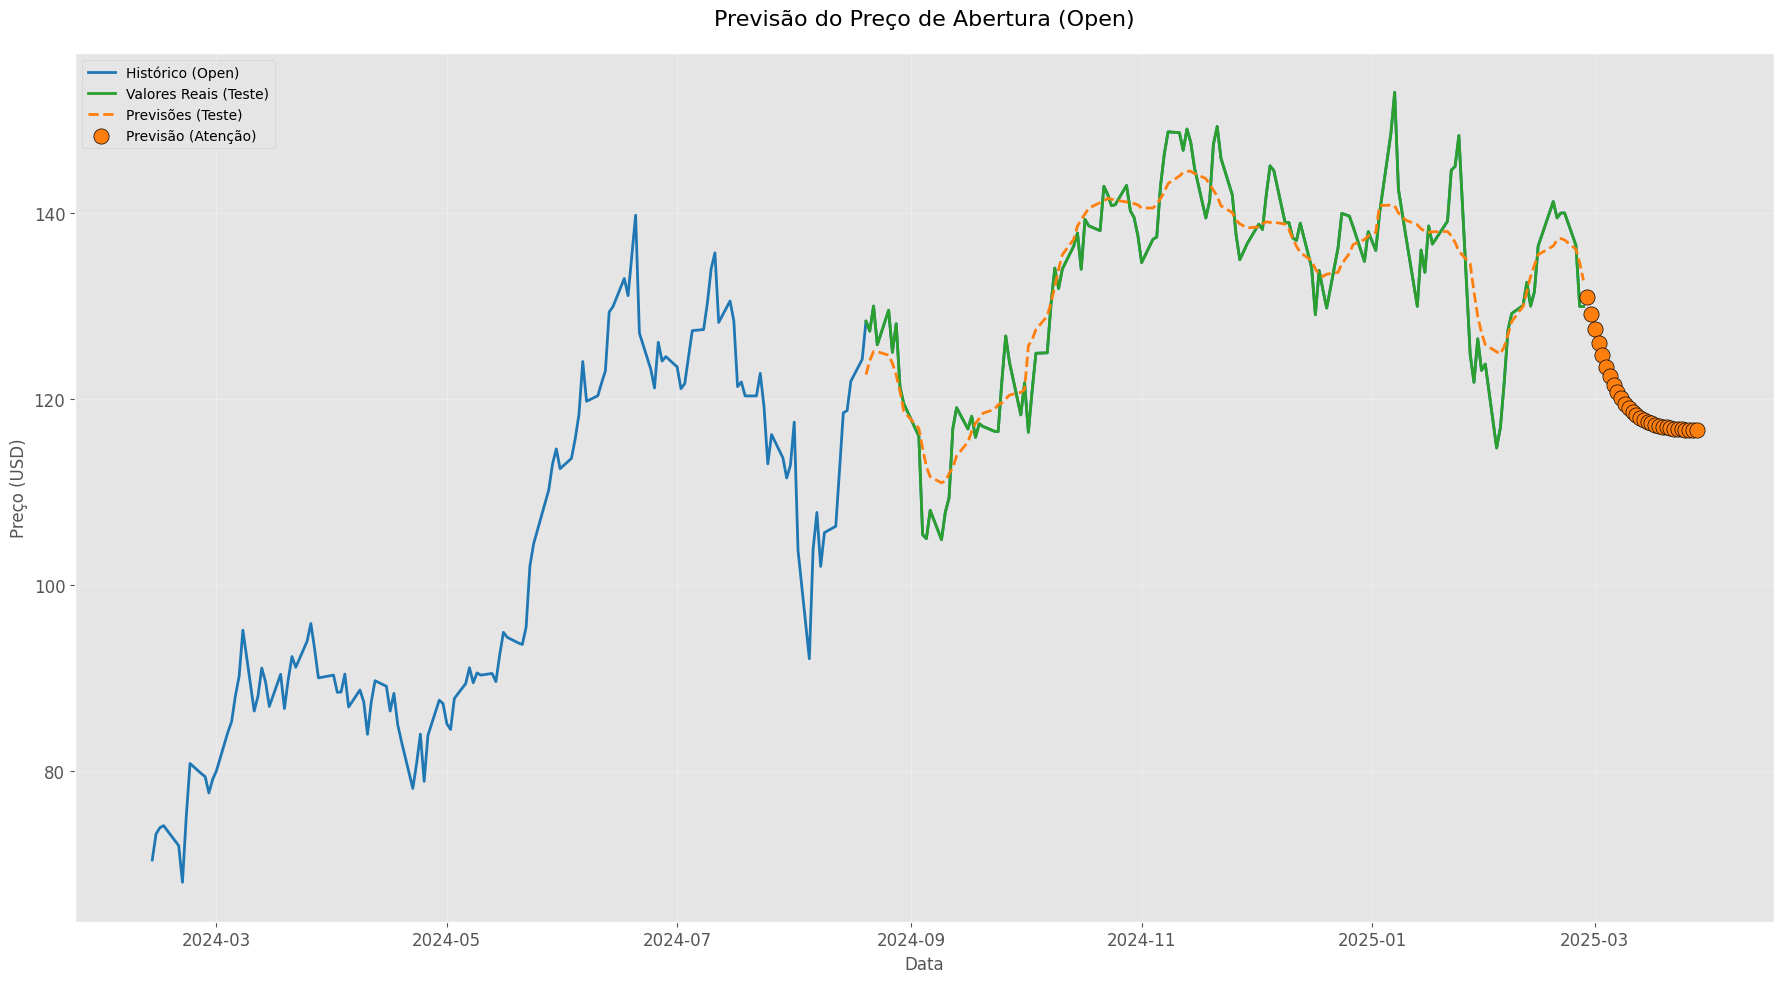


📅 PREVISÕES PARA OS PRÓXIMOS 30 DIAS:
+------------+------------------+-----------------+
| Date       | Predicted_Open   | Health_Status   |
+============+==================+=================+
| 2025-02-27 | $130.94          | Atenção         |
+------------+------------------+-----------------+
| 2025-02-28 | $129.21          | Atenção         |
+------------+------------------+-----------------+
| 2025-03-01 | $127.57          | Atenção         |
+------------+------------------+-----------------+
| 2025-03-02 | $126.06          | Atenção         |
+------------+------------------+-----------------+
| 2025-03-03 | $124.71          | Atenção         |
+------------+------------------+-----------------+
| 2025-03-04 | $123.51          | Atenção         |
+------------+------------------+-----------------+
| 2025-03-05 | $122.46          | Atenção         |
+------------+------------------+-----------------+
| 2025-03-06 | $121.54          | Atenção         |
+------------+-----------

In [53]:
# 📌 Importações essenciais
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# 📌 Configurações
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (18, 9)
plt.rcParams['font.size'] = 12
np.random.seed(42)

# ======================
# 📌 1. PROCESSAMENTO DE DADOS DE PREÇOS (ATUALIZADO)
# ======================
class DataProcessor:
    """Processa dados históricos de preços com tratamento para 'Vol.'"""

    @staticmethod
    def load_and_clean_price_data(filepath):
        """Carrega e limpa dados de preços, aceitando 'Vol.'"""
        try:
            df = pd.read_csv(filepath, parse_dates=['Date'], index_col='Date')
            print(f"✔ Dados carregados. Colunas disponíveis: {list(df.columns)}")

            # Verifica colunas essenciais (aceita 'Vol.' ou 'Volume')
            required_cols = ['Open', 'High', 'Low']
            missing_cols = [col for col in required_cols if col not in df.columns]
            if missing_cols:
                raise ValueError(f"Colunas essenciais faltando: {missing_cols}")

            # Renomeia 'Vol.' para 'Volume' se existir
            if 'Vol.' in df.columns:
                df = df.rename(columns={'Vol.': 'Volume'})
            elif 'Volume' not in df.columns:
                print("⚠️ Coluna de volume não encontrada (esperado 'Vol.' ou 'Volume') - criando coluna vazia")
                df['Volume'] = 0

            # Processamento do Volume
            if 'Volume' in df.columns:
                df['Volume'] = df['Volume'].replace({'K':'*1e3', 'M':'*1e6', 'B':'*1e9'}, regex=True)\
                                          .map(pd.eval).astype(float)

            # Processamento de Change %
            if 'Change %' in df.columns:
                df['Change_Pct'] = df['Change %'].str.replace('%','').astype(float)/100
            elif 'Change_Pct' not in df.columns:
                df['Change_Pct'] = 0

            return df.dropna()
        except Exception as e:
            print(f"❌ Erro ao carregar dados: {str(e)}")
            raise

    @staticmethod
    def create_technical_features(df):
        """Cria indicadores técnicos com tratamento robusto"""
        df = df.copy()

        try:
            # Features básicas
            df['Range'] = df['High'] - df['Low']
            df['Avg_Price'] = df[['High','Low','Open']].mean(axis=1)

            # Médias móveis
            for window in [5, 10, 20]:
                df[f'MA_{window}'] = df['Open'].rolling(window).mean()

            # Volatilidade e Momentum
            df['Volatility'] = df['Open'].rolling(20).std()
            df['Momentum_5'] = df['Open'].diff(5)
            df['Momentum_10'] = df['Open'].diff(10)

            # RSI com tratamento para divisão por zero
            delta = df['Open'].diff()
            gain = delta.where(delta > 0, 0)
            loss = -delta.where(delta < 0, 0)

            avg_gain = gain.rolling(14).mean()
            avg_loss = loss.rolling(14).mean()

            with np.errstate(divide='ignore', invalid='ignore'):
                rs = avg_gain / avg_loss
                df['RSI'] = 100 - (100 / (1 + rs.replace([np.inf, -np.inf], np.nan)))

            return df.dropna()
        except Exception as e:
            print(f"❌ Erro ao criar features técnicas: {str(e)}")
            raise

# ======================
# 📌 2. ANÁLISE FINANCEIRA (MANTIDO)
# ======================
class FinancialHealthAnalyzer:
    """Processa dados financeiros fundamentais"""

    @staticmethod
    def load_financial_data(filepath):
        """Carrega e processa dados financeiros"""
        try:
            df = pd.read_csv(filepath, parse_dates=['Report Date'])
            print(f"✔ Dados financeiros carregados. Colunas: {list(df.columns)}")

            # Processamento numérico
            num_cols = ['Revenue', 'Gross Profit', 'Operating Income',
                       'Net Income', 'EPS', 'EBITDA']
            for col in num_cols:
                if col in df.columns:
                    df[col] = df[col].replace(r'[^\d.-]', '', regex=True).astype(float)
                else:
                    print(f"⚠️ Coluna {col} não encontrada - preenchendo com 0")
                    df[col] = 0

            # Métricas calculadas
            df['Revenue_Growth_QoQ'] = df['Revenue'].pct_change().fillna(0)
            df['Profitability_Ratio'] = (df['Net Income'] / df['Revenue'].replace(0, np.nan)).fillna(0)

            return df.set_index('Report Date').ffill().dropna()
        except Exception as e:
            print(f"❌ Erro ao processar dados financeiros: {str(e)}")
            raise

    @staticmethod
    def calculate_z_score(df):
        """Calcula Z-Score com fallback para dados incompletos"""
        try:
            # Versão flexível do Z-Score
            factors = {
                'working_capital': ('Current Assets', 'Total Assets', 1.2),
                'retained_earnings': ('Retained Earnings', 'Total Assets', 1.4),
                'operating_income': ('Operating Income', 'Total Assets', 3.3),
                'market_value': ('Market Cap', 'Total Liabilities', 0.6),
                'sales': ('Revenue', 'Total Assets', 1.0)
            }

            z_score = 0
            available_factors = 0

            for factor, (num, den, weight) in factors.items():
                if num in df.columns and den in df.columns:
                    with np.errstate(divide='ignore', invalid='ignore'):
                        ratio = df[num] / df[den].replace(0, np.nan)
                        z_score += np.nan_to_num(ratio, nan=0) * weight
                        available_factors += 1

            if available_factors > 0:
                df['Z_Score'] = z_score
            else:
                # Fallback simplificado se faltarem muitas colunas
                df['Z_Score'] = (3.3 * df['Operating Income'] + df['Net Income']) / df['Revenue'].replace(0, np.nan)
                df['Z_Score'] = df['Z_Score'].fillna(0)

            # Classificação de saúde
            conditions = [
                (df['Z_Score'] < 1.8) | (df['Z_Score'].isna()),
                (df['Z_Score'] >= 1.8) & (df['Z_Score'] < 3.0),
                (df['Z_Score'] >= 3.0)
            ]
            choices = ['Risco Alto', 'Atenção', 'Saudável']
            df['Health_Status'] = np.select(conditions, choices, default='Atenção')

            return df
        except Exception as e:
            print(f"⚠️ Erro no cálculo do Z-Score: {str(e)}")
            df['Health_Status'] = 'Atenção'
            return df

# ======================
# 📌 3. MODELO PREDITIVO (MANTIDO)
# ======================
class HybridStockModel:
    """Modelo híbrido LSTM + Fundamentos para prever Open"""

    def __init__(self, time_steps=60):
        self.time_steps = time_steps
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.health_status_mapping = {'Risco Alto': 0, 'Atenção': 0.5, 'Saudável': 1}
        self.tech_features = None
        self.fin_features = None
        self.model = None

    def _build_model(self):
        """Constroi modelo dinamicamente baseado nas features disponíveis"""
        ts_input = Input(shape=(self.time_steps, self.tech_features))
        lstm_layer = LSTM(128, return_sequences=True, activation='tanh')(ts_input)
        lstm_layer = Dropout(0.3)(lstm_layer)
        lstm_out = LSTM(64)(lstm_layer)

        fin_input = Input(shape=(self.fin_features,))
        combined = Concatenate()([lstm_out, fin_input])

        dense = Dense(64, activation='relu')(combined)
        dense = Dropout(0.2)(dense)
        output = Dense(1)(dense)

        model = Model(inputs=[ts_input, fin_input], outputs=output)
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        return model

    def prepare_data(self, df, target_col='Open'):
        """Prepara dados adaptando-se às colunas disponíveis"""
        try:
            # Listas de features possíveis
            possible_tech_features = [
                'Open', 'High', 'Low', 'Volume', 'Range', 'Avg_Price',
                'MA_5', 'MA_10', 'MA_20', 'Volatility', 'RSI',
                'Momentum_5', 'Momentum_10', 'Change_Pct'
            ]

            possible_fin_features = [
                'Revenue', 'Net Income', 'EPS',
                'Revenue_Growth_QoQ', 'Profitability_Ratio', 'Z_Score'
            ]

            # Selecionar apenas features que existem no DataFrame
            tech_features = [f for f in possible_tech_features if f in df.columns]
            fin_features = [f for f in possible_fin_features if f in df.columns]

            print(f"\n🔧 Features técnicas selecionadas ({len(tech_features)}): {tech_features}")
            print(f"🔧 Features financeiras selecionadas ({len(fin_features)}): {fin_features}")

            # Verificar se a target_col existe
            if target_col not in tech_features:
                raise ValueError(f"Coluna alvo '{target_col}' não encontrada nas features técnicas")

            # Criar scalers separados
            tech_scaler = MinMaxScaler(feature_range=(0, 1))
            fin_scaler = MinMaxScaler(feature_range=(0, 1))

            # Normalizar dados
            tech_scaled = tech_scaler.fit_transform(df[tech_features])
            fin_scaled = fin_scaler.fit_transform(df[fin_features])

            # Armazenar scalers para uso futuro
            self.tech_scaler = tech_scaler
            self.fin_scaler = fin_scaler

            # Preparar sequências
            X_tech, X_fin, y = [], [], []
            for i in range(self.time_steps, len(df)):
                X_tech.append(tech_scaled[i-self.time_steps:i])
                X_fin.append(fin_scaled[i-1])  # Usamos apenas o ponto mais recente dos dados financeiros
                y.append(tech_scaled[i, tech_features.index(target_col)])

            # Converter para arrays numpy
            X_tech = np.array(X_tech)
            X_fin = np.array(X_fin)
            y = np.array(y)

            # Divisão treino/teste
            split = int(0.8 * len(X_tech))
            X_train, X_test = X_tech[:split], X_tech[split:]
            X_train_fin, X_test_fin = X_fin[:split], X_fin[split:]
            y_train, y_test = y[:split], y[split:]

            # Atualizar contagens de features
            self.tech_features = len(tech_features)
            self.fin_features = len(fin_features)
            self.model = self._build_model()

            return (X_train, X_train_fin, y_train), (X_test, X_test_fin, y_test)
        except Exception as e:
            print(f"❌ Erro ao preparar dados: {str(e)}")
            raise
    def train(self, train_data, val_data, epochs=100, batch_size=32):
        """Treina o modelo com tratamento de erros"""
        try:
            (X_train, X_train_fin, y_train) = train_data
            (X_val, X_val_fin, y_val) = val_data

            early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

            history = self.model.fit(
                [X_train, X_train_fin], y_train,
                validation_data=([X_val, X_val_fin], y_val),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=[early_stop],
                verbose=1
            )
            return history
        except Exception as e:
            print(f"❌ Erro ao treinar modelo: {str(e)}")
            raise

    def evaluate(self, test_data):
        """Avalia o modelo com tratamento seguro"""
        try:
            X_test, X_test_fin, y_test = test_data
            y_pred = self.model.predict([X_test, X_test_fin], verbose=0)

            # Reconstruir dados para inversão do scaler
            # Criar array dummy com todas as features técnicas
            dummy_array = np.zeros((len(y_test), self.tech_features))

            # Preencher com valores médios (exceto a target)
            for i in range(self.tech_features):
                dummy_array[:, i] = np.mean(X_test[:, :, i])

            # Substituir a coluna da target pelos valores reais
            if hasattr(self.tech_scaler, 'feature_names_in_'):
                # Versão moderna do scikit-learn
                if 'Open' in self.tech_scaler.feature_names_in_:
                    open_idx = list(self.tech_scaler.feature_names_in_).index('Open')
                    dummy_array[:, open_idx] = y_test
                    y_test_inv = self.tech_scaler.inverse_transform(dummy_array)[:, open_idx]

                    dummy_array[:, open_idx] = y_pred.flatten()
                    y_pred_inv = self.tech_scaler.inverse_transform(dummy_array)[:, open_idx]
                else:
                    raise ValueError("Coluna 'Open' não encontrada nas features técnicas")
            else:
                # Fallback para versões antigas do scikit-learn
                # Assumindo que 'Open' é a primeira coluna (ajuste conforme necessário)
                dummy_array[:, 0] = y_test
                y_test_inv = self.tech_scaler.inverse_transform(dummy_array)[:, 0]

                dummy_array[:, 0] = y_pred.flatten()
                y_pred_inv = self.tech_scaler.inverse_transform(dummy_array)[:, 0]

            mae = mean_absolute_error(y_test_inv, y_pred_inv)
            rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

            return mae, rmse, y_test_inv, y_pred_inv
        except Exception as e:
            print(f"❌ Erro ao avaliar modelo: {str(e)}")
            raise

    def predict_future(self, df, days=30):
          """Gera previsões futuras com verificação de dados"""
          try:
              if self.model is None:
                  raise ValueError("Modelo não foi treinado. Execute prepare_data e train primeiro.")

              # Obter lista de features técnicas usadas no treino
              if hasattr(self.tech_scaler, 'feature_names_in_'):
                  tech_cols = list(self.tech_scaler.feature_names_in_)
              else:
                  # Fallback - assumindo a mesma ordem usada no prepare_data
                  tech_cols = ['Open', 'High', 'Low', 'Volume', 'Range', 'Avg_Price',
                              'MA_5', 'MA_10', 'MA_20', 'Volatility', 'RSI',
                              'Momentum_5', 'Momentum_10', 'Change_Pct']
                  tech_cols = [col for col in tech_cols if col in df.columns]

              # Verificar e preencher colunas faltantes
              missing_cols = [col for col in tech_cols if col not in df.columns]
              if missing_cols:
                  print(f"⚠️ Colunas faltando: {missing_cols} - preenchendo com 0")
                  for col in missing_cols:
                      df[col] = 0

              # Obter dados mais recentes
              current_tech = df[tech_cols].values[-self.time_steps:]
              current_tech_scaled = self.tech_scaler.transform(current_tech)

              # Obter dados financeiros (se existirem)
              if hasattr(self, 'fin_scaler') and self.fin_features > 0:
                  if hasattr(self.fin_scaler, 'feature_names_in_'):
                      fin_cols = list(self.fin_scaler.feature_names_in_)
                  else:
                      fin_cols = ['Revenue', 'Net Income', 'EPS',
                                'Revenue_Growth_QoQ', 'Profitability_Ratio', 'Z_Score']
                      fin_cols = [col for col in fin_cols if col in df.columns]

                  current_fin = df[fin_cols].values[-1]
                  current_fin_scaled = self.fin_scaler.transform([current_fin])
              else:
                  current_fin_scaled = np.zeros((1, self.fin_features))

              predictions = []
              health_status = []

              for _ in range(days):
                  X_tech_input = current_tech_scaled[-self.time_steps:].reshape(1, self.time_steps, -1)
                  X_fin_input = current_fin_scaled

                  pred = self.model.predict([X_tech_input, X_fin_input], verbose=0)[0][0]

                  # Criar nova linha com a previsão
                  new_tech_row = current_tech_scaled[-1].copy()
                  if 'Open' in tech_cols:
                      open_idx = tech_cols.index('Open')
                      new_tech_row[open_idx] = pred
                  current_tech_scaled = np.vstack([current_tech_scaled, new_tech_row])

                  # Inverter a normalização para obter valor real
                  dummy_tech = np.zeros((1, len(tech_cols)))
                  dummy_tech[0] = new_tech_row
                  pred_inv = self.tech_scaler.inverse_transform(dummy_tech)

                  if 'Open' in tech_cols:
                      predictions.append(pred_inv[0, tech_cols.index('Open')])
                  else:
                      predictions.append(pred)

                  health_status.append(df['Health_Status'].iloc[-1] if 'Health_Status' in df.columns else 'Atenção')

              future_dates = pd.date_range(start=df.index[-1], periods=days+1, freq='D')[1:]
              return pd.DataFrame({
                  'Date': future_dates,
                  'Predicted_Open': predictions,
                  'Health_Status': health_status
              })
          except Exception as e:
              print(f"❌ Erro ao gerar previsões: {str(e)}")
              raise

# ======================
# 📌 4. FUNÇÃO PRINCIPAL
# ======================
def main():
    print("=== SISTEMA DE PREVISÃO DE PREÇOS ===")
    print("(Modelo Híbrido LSTM + Análise Fundamentalista)\n")

    try:
        # 1. Upload de arquivos
        print("1. Faça upload do arquivo de preços (ex: NVDA.csv)")
        price_uploaded = files.upload()
        price_file = list(price_uploaded.keys())[0]

        print("\n2. Faça upload do arquivo financeiro (ex: NVDA_Financials.csv)")
        financial_uploaded = files.upload()
        financial_file = list(financial_uploaded.keys())[0]

        # 2. Processamento de dados
        print("\n3. Processando dados de preços...")
        price_data = DataProcessor.load_and_clean_price_data(price_file)
        price_data = DataProcessor.create_technical_features(price_data)

        print("\n4. Processando dados financeiros...")
        financial_data = FinancialHealthAnalyzer.load_financial_data(financial_file)
        financial_data = FinancialHealthAnalyzer.calculate_z_score(financial_data)

        # 3. Combinação de dados
        print("\n5. Combinando dados...")
        merged_data = pd.merge_asof(
            price_data.sort_index(),
            financial_data.sort_index(),
            left_index=True,
            right_index=True,
            direction='backward'
        ).ffill().dropna()

        print(f"✔ Dados combinados. Período: {merged_data.index[0].date()} a {merged_data.index[-1].date()}")

        # 4. Modelagem
        print("\n6. Preparando modelo...")
        model = HybridStockModel(time_steps=60)
        train_data, test_data = model.prepare_data(merged_data)

        print("\n7. Treinando modelo...")
        history = model.train(train_data, test_data, epochs=50, batch_size=32)

        print("\n8. Avaliando modelo...")
        mae, rmse, y_test, y_pred = model.evaluate(test_data)

        print(f"\n📊 DESEMPENHO DO MODELO:")
        print(f"• Erro Médio Absoluto (MAE): ${mae:.2f}")
        print(f"• Raiz do Erro Quadrático Médio (RMSE): ${rmse:.2f}")

        # 5. Previsões
        print("\n9. Gerando previsões para 30 dias...")
        future_predictions = model.predict_future(merged_data, days=30)

        # 6. Visualização
        print("\n10. Gerando visualizações...")
        plt.figure(figsize=(18, 10))

        plt.plot(merged_data.index[-len(y_test)*2:],
                 merged_data['Open'][-len(y_test)*2:],
                 label='Histórico (Open)', color='#1f77b4', linewidth=2)

        plt.plot(merged_data.index[-len(y_test):], y_test,
                 label='Valores Reais (Teste)', color='#2ca02c', linewidth=2)
        plt.plot(merged_data.index[-len(y_test):], y_pred,
                 label='Previsões (Teste)', color='#ff7f0e', linestyle='--', linewidth=2)

        colors = {'Saudável': '#2ca02c', 'Atenção': '#ff7f0e', 'Risco Alto': '#d62728'}
        for status, color in colors.items():
            subset = future_predictions[future_predictions['Health_Status'] == status]
            if not subset.empty:
                plt.scatter(subset['Date'], subset['Predicted_Open'],
                           color=color, s=120, edgecolor='black',
                           label=f'Previsão ({status})', zorder=5)

        plt.title('Previsão do Preço de Abertura (Open)', fontsize=16, pad=20)
        plt.xlabel('Data', fontsize=12)
        plt.ylabel('Preço (USD)', fontsize=12)
        plt.legend(fontsize=10, loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        print("\n📅 PREVISÕES PARA OS PRÓXIMOS 30 DIAS:")
        future_predictions['Date'] = future_predictions['Date'].dt.strftime('%Y-%m-%d')
        future_predictions['Predicted_Open'] = future_predictions['Predicted_Open'].apply(lambda x: f"${x:.2f}")
        print(future_predictions[['Date', 'Predicted_Open', 'Health_Status']].to_markdown(index=False, tablefmt="grid"))

    except Exception as e:
        print(f"\n❌ ERRO NO PROCESSAMENTO: {str(e)}")

if __name__ == "__main__":
    main()